In [1]:
from scipy import stats
import os
import sys
sys.path.append('../..')
import seaborn as sns
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice, fig4_plotting_colours
from utils.post_processing_utils import get_all_experimental_records
from utils.plotting_visuals import makes_plots_pretty
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import statsmodels.api as sm
from utils.plotting import output_significance_stars_from_pval

In [2]:
def shift_respecting_index(vals_to_shift, shift_size):
    """
    Shifts a pandas df column by shift_size indices
    but if there is a discontinuity in the index,
    replaces the shifted index with nan
    """
    
    shifted_vals = vals_to_shift.shift(periods=shift_size)

    # Detect discontinuities in the index
    trial_num_diff = vals_to_shift.index.to_series().diff().fillna(shift_size)

    # Identify where the shift should result in NaN due to discontinuities
    discontinuities = trial_num_diff > np.abs(shift_size)
    shifted_vals[discontinuities] = np.nan

    return shifted_vals


In [139]:
recording_site = 'tail'
if recording_site == 'Nacc':
    file_ext = '_reward'
    # for nacc reward this doesn't include non-punished sessions
    # (these responses will be aligned to the reward rather than the first incorrect choice)
    # so need to select for correct trials using 'First choice correct'
else:
    file_ext = ''
mice = change_over_time_mice[recording_site]
num_mice = len(mice)

results = {}
for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}{}.pkl'.format(mouse, file_ext))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')
    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
   
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)
    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})
    all_session_data['next_stim'] = shift_respecting_index(all_session_data['Trial type'], -1)
    all_session_data['next_stim_match'] = (all_session_data['next_stim'] == all_session_data['Trial type'])

    all_session_data['next_choice'] = shift_respecting_index(all_session_data['choice'], -1)
    all_session_data['next_choice_stay'] = (all_session_data['next_choice'] == all_session_data['choice'])

    recorded_trials = all_session_data[(all_session_data['trial_type'].notna())
                                       & (all_session_data['next_stim_match'] ==1)
                                      & all_session_data['First choice correct'] == 0] 
    df_for_reg = recorded_trials[['APE_peaks', 'next_choice']].copy()
    df_for_reg.loc[:, 'APE_peaks'] = df_for_reg['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

    df_for_reg.loc[:, 'APE_peaks'] = df_for_reg['APE_peaks'].astype(float)
    df_for_reg = df_for_reg.dropna()
    y = df_for_reg['next_choice']
    X = sm.add_constant(df_for_reg['APE_peaks'])
    # Fit the logistic regression model
    logit_mod = sm.Logit(y, X)
    logit_res = logit_mod.fit(disp=0)  # Set disp=0 to suppress the output for each fit
    results[mouse] = logit_res

    

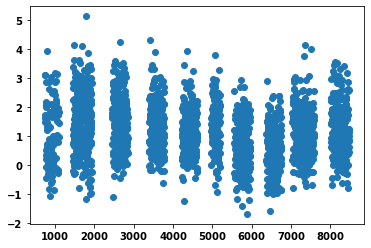

In [140]:
plt.scatter(df_for_reg['APE_peaks'].index.values, df_for_reg['APE_peaks'].values)

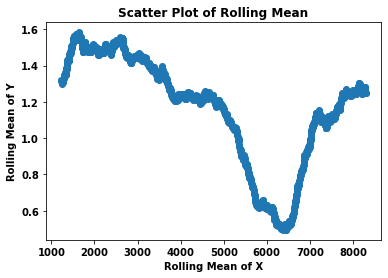

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_for_reg['APE_peaks'] is your data
x_values = df_for_reg['APE_peaks'].index.values
y_values = df_for_reg['APE_peaks'].values

# Convert x_values to a Pandas Series to calculate the rolling mean
x_series = pd.Series(x_values)
y_series = pd.Series(y_values)

# Calculate the rolling mean with a window size of your choice, e.g., 5
rolling_x = x_series.rolling(window=200).mean()
rolling_y = y_series.rolling(window=200).mean()

# Create a scatter plot using the rolling means
plt.scatter(rolling_x, rolling_y)
plt.title('Scatter Plot of Rolling Mean')
plt.xlabel('Rolling Mean of X')
plt.ylabel('Rolling Mean of Y')
plt.show()


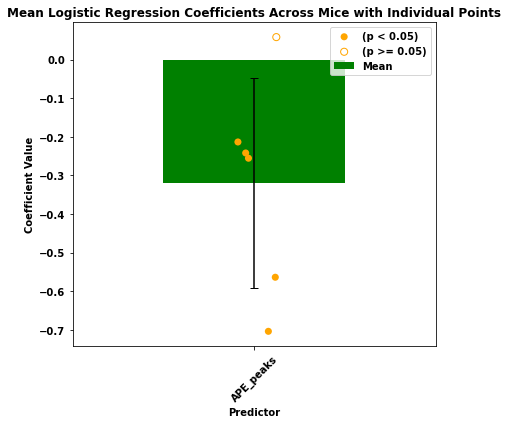

               Mean       Std  t-Statistic  p-Value  Significant
APE_peaks -0.320224  0.272571     -2.87773  0.03468         True


In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Collect the coefficients and p-values into a DataFrame
coef_data = []

# Loop through each result and collect all regressors dynamically
for mouse, result in results.items():
    data = {'Mouse': mouse}
    
    # Loop through each parameter in the result (excluding the constant term)
    for param in result.params.index:
        if param != 'const':  # Skip the constant term
            data[param] = result.params[param]
            data[f'p_{param}'] = result.pvalues[param]
    
    coef_data.append(data)

# Convert to DataFrame
coef_df = pd.DataFrame(coef_data)

# Identify all regressors dynamically (excluding Mouse and p-values)
regressors = [col for col in coef_df.columns if col not in ['Mouse'] and not col.startswith('p_')]

# Calculate the mean and standard deviation across mice for numeric columns only
coef_mean = coef_df[regressors].mean()
coef_std = coef_df[regressors].std()

# Perform a one-sample t-test against zero for each coefficient across mice
t_stats, p_values = stats.ttest_1samp(coef_df[regressors], 0)

# Create a DataFrame to store the statistics
coef_stats = pd.DataFrame({
    'Mean': coef_mean,
    'Std': coef_std,
    't-Statistic': t_stats,
    'p-Value': p_values
})

# Determine significance (p < 0.05) at the group level
coef_stats['Significant'] = coef_stats['p-Value'] < 0.05

# Plotting the coefficients with error bars
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the means with error bars (standard deviations)
coef_stats['Mean'].plot(kind='bar', yerr=coef_stats['Std'], capsize=4, ax=ax, color=coef_stats['Significant'].map({True: 'green', False: 'red'}))

# Add scatter points for individual mice with jitter
jitter_strength = 0.1  # Strength of the jitter

for i, predictor in enumerate(regressors):
    x = np.full(len(coef_df), i) + np.random.uniform(-jitter_strength, jitter_strength, len(coef_df))  # Position scatter points with jitter
    
    # Determine if individual mouse coefficient is significant
    sig_mask = coef_df[f'p_{predictor}'] < 0.05
    
    # Plot filled scatter points for significant coefficients
    ax.scatter(x[sig_mask], coef_df[predictor][sig_mask], color='orange', edgecolor='none', s=50, zorder=3, label='(p < 0.05)' if i == 0 else "")
    
    # Plot unfilled scatter points for non-significant coefficients
    ax.scatter(x[~sig_mask], coef_df[predictor][~sig_mask], facecolors='none', edgecolor='orange', s=50, zorder=3, label='(p >= 0.05)' if i == 0 else "")

# Customize the plot
plt.title('Mean Logistic Regression Coefficients Across Mice with Individual Points')
plt.ylabel('Coefficient Value')
plt.xlabel('Predictor')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

# Display the statistical significance table
print(coef_stats)


In [5]:
coef_df

,Mouse,APE_peaks,p_APE_peaks
0,SNL_photo16,0.054876,0.374411
1,SNL_photo17,-0.063367,0.124086
2,SNL_photo18,-0.005430,0.927238
3,SNL_photo21,-0.057575,0.369995
4,SNL_photo22,0.157306,0.003028
5,SNL_photo26,0.044036,0.419710
